### Appendix G: CVAE Data Exploration

In [ ]:
!pip install tensorflow --quiet
!pip install disutils --quiet
!pip install pandas --quiet
!pip install scipy --quiet
!pip install scikit-learn --quiet
!pip install opencv-python --quiet

In [30]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Layer, Reshape, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Mean, Metric
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.backend import random_normal

Found 5960 images across 62 classes

Class distribution:


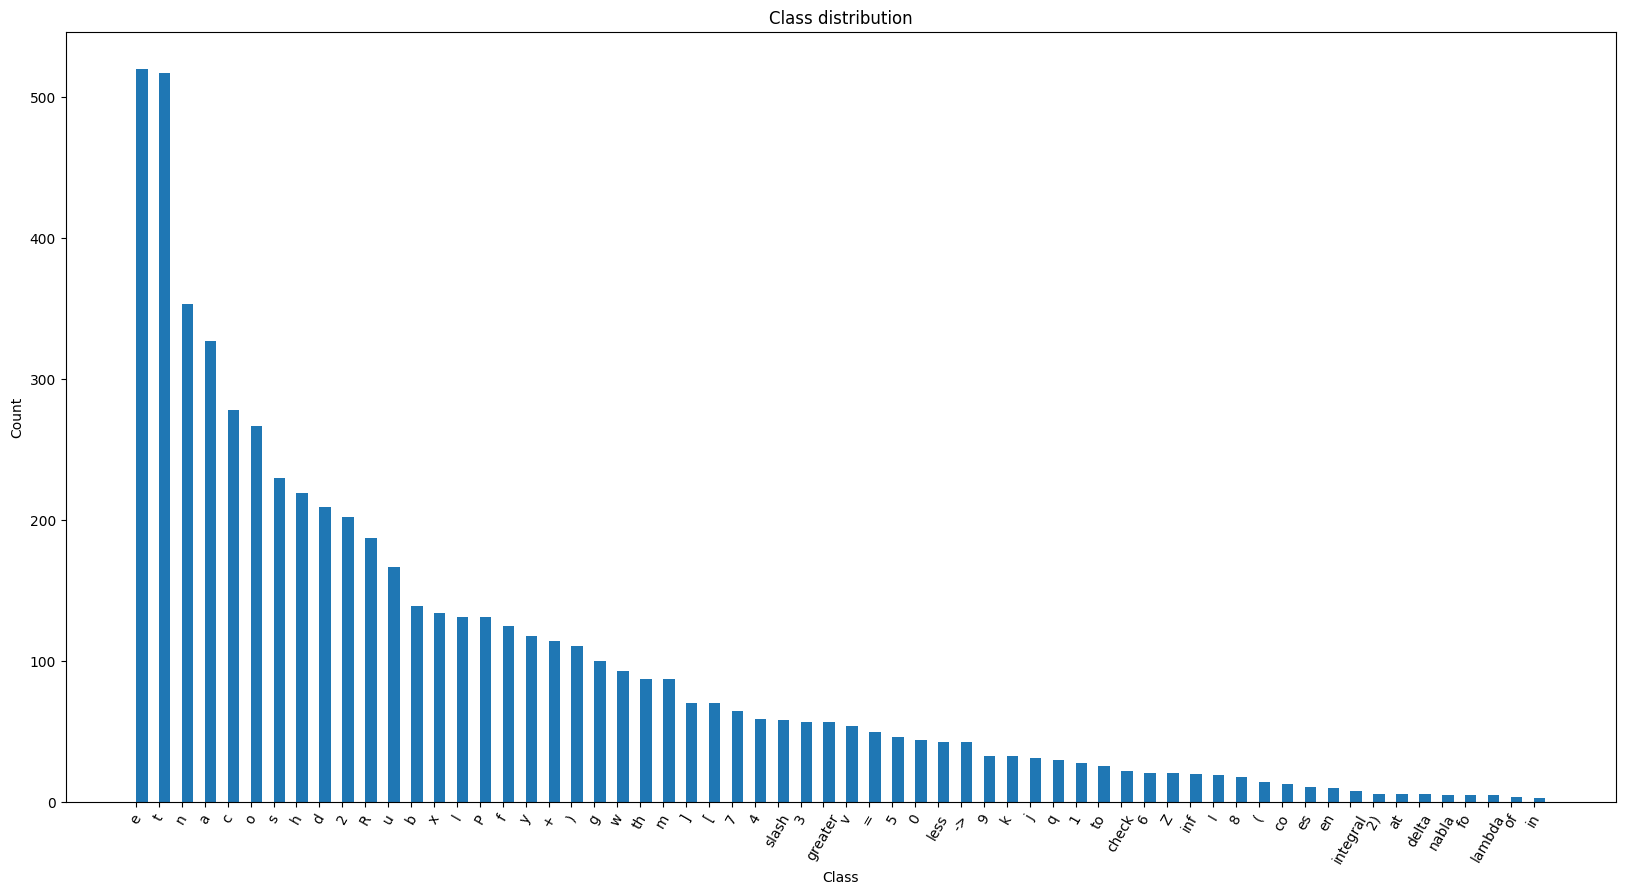

In [24]:
# Loading the labeled dataset and exploring the distributions

import os
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def create_dataset_from_folders(base_dir):
    """
    Create a DataFrame from images organized in class folders
    
    Args:
        base_dir: Path to directory containing class folders
        
    Returns:
        DataFrame with columns ['image_paths', 'label']
    """
    # Lists to store paths and labels
    image_paths = []
    labels = []
    
    # Walk through all subdirectories
    for class_name in os.listdir(base_dir):
        class_dir = os.path.join(base_dir, class_name)
        if not os.path.isdir(class_dir):
            continue
            
        # Get all PNG images in this class directory
        class_images = glob(os.path.join(class_dir, '*.png'))
        
        # Add to our lists
        image_paths.extend(class_images)
        labels.extend([class_name] * len(class_images))
    
    # Create DataFrame
    df = pd.DataFrame({
        'image_paths': image_paths,
        'label': labels
    })

    # Create a histogram showing the class distribution
    print(f"Found {len(df)} images across {len(df['label'].unique())} classes")
    print("\nClass distribution:")
    label_counts = df['label'].value_counts().to_dict()

    # Plot the histogram
    plt.figure(figsize=(20, 10))
    plt.bar(label_counts.keys(), label_counts.values(), width=0.5, align='edge')
    plt.xticks(rotation=60)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Class distribution')
    plt.show()
    
    return df

# Usage:
df = create_dataset_from_folders('labeled_dataset')

In [27]:
import numpy as np

def balance_dataset(df, min_samples=50, max_samples=300):
    """
    Balance dataset using a hybrid approach:
    - Classes with < min_samples: Heavy augmentation
    - Classes between min and max: Moderate augmentation
    - Classes > max_samples: Undersampling
    """
    balanced_df = pd.DataFrame()
    
    # Configure augmentation for minority classes
    minority_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=False,
        fill_mode='nearest'
    )
    
    # Configure lighter augmentation for medium classes
    medium_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        width_shift_range=0.05,
        height_shift_range=0.05,
        fill_mode='nearest'
    )
    
    for label in df['label'].unique():
        # Skip classes that are not to be balanced
        if label in ['greater', 'slash', 'less', 'check', 'integral', '->', '2)', 'at', 'co', 'delta', 'en', 'es', 'fo', 'in', 'inf', 'lambda', 'nabla', 'of', 'to']:
            continue

        class_df = df[df['label'] == label]
        class_size = len(class_df)
        
        if class_size < min_samples:
            # Heavy augmentation for minority classes
            multiplier = int(np.ceil(min_samples / class_size))
            augmented_df = class_df.copy()
            
            # Replicate the class_df multiplier-1 times (original + copies = multiplier)
            for i in range(multiplier - 1):
                augmented_df = pd.concat([augmented_df, class_df])
            
            balanced_df = pd.concat([balanced_df, augmented_df])
            print(f"Class {label}: {class_size} → {len(augmented_df)} (heavy augmentation)")
            
        elif class_size > max_samples:
            # Undersample majority classes
            sampled_df = class_df.sample(n=max_samples, random_state=42)
            balanced_df = pd.concat([balanced_df, sampled_df])
            print(f"Class {label}: {class_size} → {max_samples} (undersampled)")
            
        else:
            # Keep medium classes as is
            balanced_df = pd.concat([balanced_df, class_df])
            print(f"Class {label}: {class_size} (unchanged)")
    
    return balanced_df.reset_index(drop=True)

# Use the function
balanced_df = balance_dataset(df, min_samples=30, max_samples=300)

Class R: 187 (unchanged)
Class u: 167 (unchanged)
Class 9: 33 (unchanged)
Class 0: 44 (unchanged)
Class 7: 65 (unchanged)
Class I: 19 → 38 (heavy augmentation)
Class n: 353 → 300 (undersampled)
Class g: 100 (unchanged)
Class +: 114 (unchanged)
Class 6: 21 → 42 (heavy augmentation)
Class Z: 21 → 42 (heavy augmentation)
Class 1: 28 → 56 (heavy augmentation)
Class 8: 18 → 36 (heavy augmentation)
Class t: 517 → 300 (undersampled)
Class s: 230 (unchanged)
Class a: 327 → 300 (undersampled)
Class f: 125 (unchanged)
Class o: 267 (unchanged)
Class h: 219 (unchanged)
Class m: 87 (unchanged)
Class j: 31 (unchanged)
Class c: 278 (unchanged)
Class ]: 70 (unchanged)
Class (: 14 → 42 (heavy augmentation)
Class d: 209 (unchanged)
Class v: 54 (unchanged)
Class q: 30 (unchanged)
Class =: 50 (unchanged)
Class 4: 59 (unchanged)
Class x: 134 (unchanged)
Class th: 87 (unchanged)
Class 3: 57 (unchanged)
Class e: 520 → 300 (undersampled)
Class ): 111 (unchanged)
Class [: 70 (unchanged)
Class b: 139 (unchanged


Class distribution:


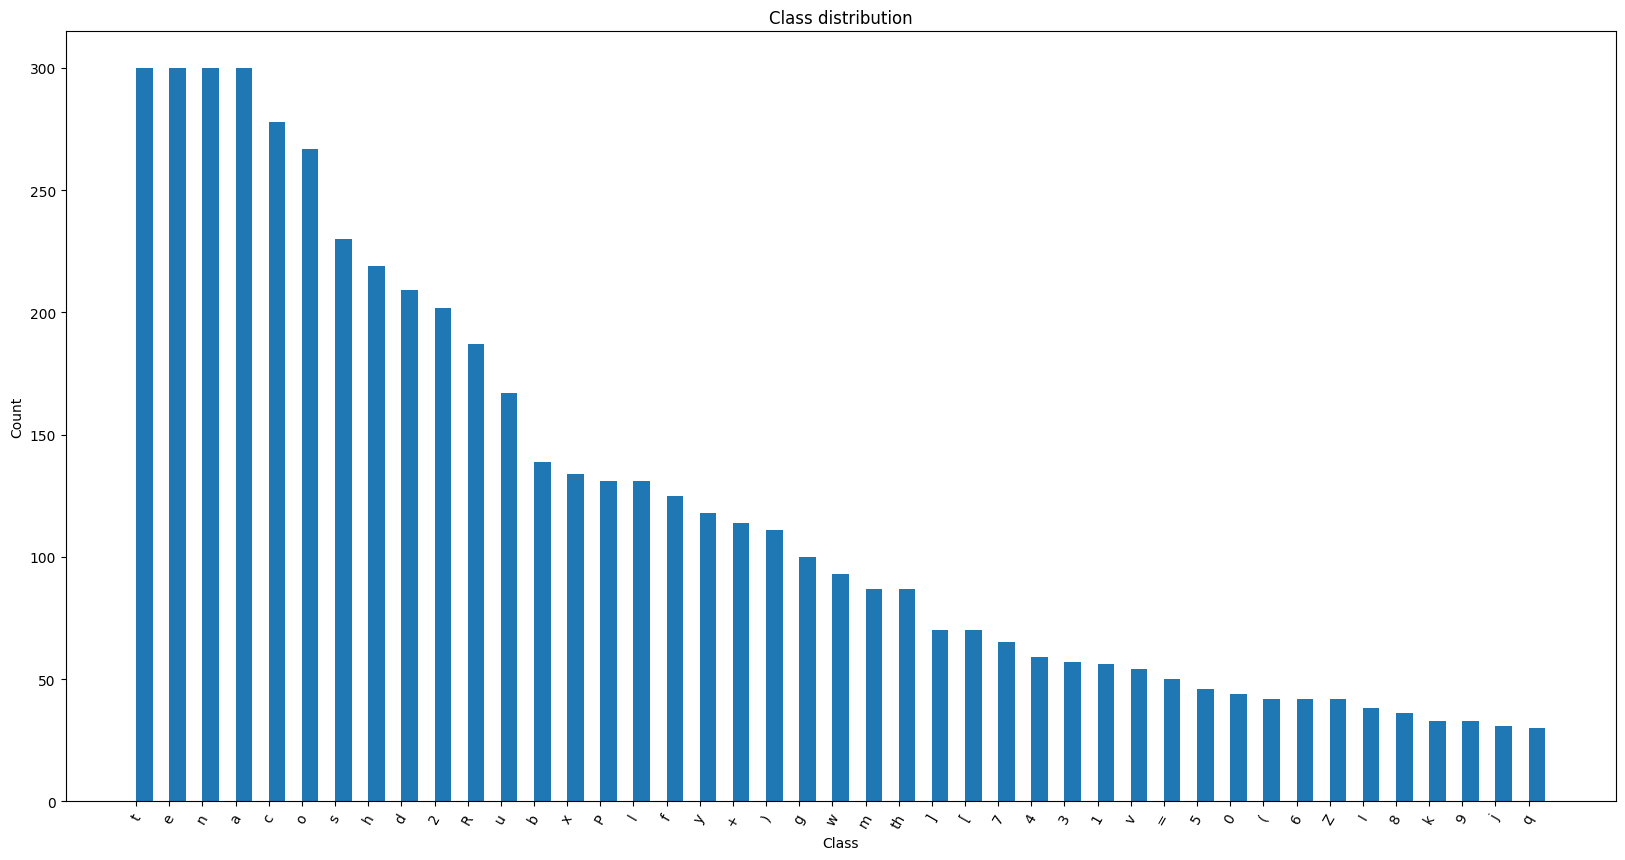

In [28]:
print("\nClass distribution:")
label_counts = balanced_df['label'].value_counts().to_dict()

# Plot the histogram
plt.figure(figsize=(20, 10))
plt.bar(label_counts.keys(), label_counts.values(), width=0.5, align='edge')
plt.xticks(rotation=60)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class distribution')
plt.show()

In [54]:
# Create train/test split
train_df, test_df = train_test_split(balanced_df, test_size=0.2, stratify=balanced_df['label'], random_state=42)

# Create data generators with appropriate augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_paths',
    y_col='label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_paths',
    y_col='label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False
)

Found 4181 validated image filenames belonging to 43 classes.
Found 1046 validated image filenames belonging to 43 classes.


### Appendix H: CVAE Training

In [67]:
# Define the sampling layer
class Sampling(Layer):
  '''
  Uses (z_mean, z_log_var) to sample z, the vector encoding a digit.
  '''

  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = random_normal(shape=(batch, dim))

    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Encoder model
def encoder_model(input_shape, num_classes, filters, dense_layer_dim, latent_dim):
  '''
  Define the encoder model that maps the image to a lower dimensional space

  '''
  print('Input shape is:', input_shape)
  # Creating the input layer
  image_input = Input(shape=input_shape)
  label_input = Input(shape=(num_classes,))


  encoder_layers_dim = {
    'input_shape': tuple(image_input.shape[1:]),
    'conv_layers': [],
    'flattened_dim': None,
    'dense_layer_dim': dense_layer_dim,
    'latent_dim': latent_dim,
    'num_classes': num_classes
  }

  x = Conv2D(filters[0], (3, 3), activation='relu', strides=2, padding='same')(image_input)
  encoder_layers_dim['conv_layers'].append(tuple(x.shape[1:]))

  # Middle layers
  middle_layers = [Conv2D(f, 3, activation='relu', strides=2, padding='same') for f in filters[1:]]

  for mid_layer in middle_layers:
    x = mid_layer(x)
    encoder_layers_dim['conv_layers'].append(tuple(x.shape[1:]))

  # Flatten the conv layer output in prep for dense layers
  x = Flatten()(x)
  encoder_layers_dim['flattened_dim'] = tuple(x.shape[1:])

  # Concatenate the label input with the flattened conv layer output
  x = Concatenate()([x, label_input])

  # Add dense layer with the given dense layer dimension
  x = Dense(dense_layer_dim, activation='relu')(x)

  # Define the latent space
  z_mean = Dense(latent_dim, name='z_mean')(x)
  z_log_var = Dense(latent_dim, name='z_log_var')(x)
  z = Sampling()([z_mean, z_log_var])

  return Model([image_input, label_input], [z_mean, z_log_var, z], name='encoder'), encoder_layers_dim


def decoder_model(encoder_layers_dim):
  '''
  Define the decoder model that maps the latent space to the reconstructed image
  '''

  # Get the dimensions of the encoder layers
  latent_dim = encoder_layers_dim['latent_dim']
  num_classes = encoder_layers_dim['num_classes']
  conv_shapes = encoder_layers_dim['conv_layers']
  input_shape = encoder_layers_dim['input_shape']

  # Create input layer for latent space
  latent_inputs = Input(shape=(latent_dim,))
  label_input = Input(shape=(num_classes,))

  x = Concatenate()([latent_inputs, label_input])

  # First dense layer
  x = Dense(np.prod(conv_shapes[-1]), activation='relu')(x)
  x = Reshape(conv_shapes[-1])(x)

  # Upsampling
  filters = [shape[-1] for shape in conv_shapes[:-1]]
  for f in filters[::-1]:
    x = Conv2DTranspose(f, 3, activation='relu', strides=2, padding='same')(x)

  # Apply final convolutional layer with sigmoid activation to output reconstructed image
  decoder_outputs = Conv2DTranspose(filters=input_shape[-1], 
                                    kernel_size=3, 
                                    activation="sigmoid", 
                                    padding="same",
                                    strides=2)(x)
  
  print('Decoder outputs:', decoder_outputs.shape)

  # Create and return Keras model with latent vector as input and reconstructed image as output
  return Model([latent_inputs, label_input], decoder_outputs, name="decoder")

In [72]:
class CVAE(Model):
  
  def __init__(self, encoder, decoder, **kwargs):
    super().__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder

    # Metrics we'll track during training
    self.total_loss_tracker = Mean(name="total_loss")
    self.reconstruction_loss_tracker = Mean(name="reconstruction_loss")
    self.kl_loss_tracker = Mean(name="kl_loss")

    # Metrics we'll track during validation
    self.val_total_loss_tracker = Mean(name="val_total_loss")
    self.val_reconstruction_loss_tracker = Mean(name="val_reconstruction_loss")
    self.val_kl_loss_tracker = Mean(name="val_kl_loss")

  @property
  def metrics(self):
    return [
        self.total_loss_tracker,
        self.reconstruction_loss_tracker,
        self.kl_loss_tracker,
        self.val_total_loss_tracker,
        self.val_reconstruction_loss_tracker,
        self.val_kl_loss_tracker,
    ]

  # Define forward pass
  def call(self, input):
    if not isinstance(input, (list, tuple)):
      raise ValueError("Expected inputs to be a tuple of (images, labels)")
    
    images, labels = input 
    z_mean, z_log_var, z = self.encoder([images, labels])
    reconstruction = self.decoder([z, labels])
    return z_mean, z_log_var, z, reconstruction

  # Training step
  def train_step(self, data):
    if isinstance(data, tuple):
      images, labels = data

    else:
      raise ValueError("Expected data to be a tuple of (images, labels)")

    with tf.GradientTape() as tape:
      # Forward pass
      z_mean, z_log_var, z, reconstruction = self(data)

      # Compute reconstruction loss
      reconstruction_loss = tf.reduce_mean(
          tf.reduce_sum(
              tf.keras.losses.binary_crossentropy(images, reconstruction), axis=(1, 2)
          ))

      # Compute KL divergence loss
      kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
      kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

      # Compute total loss
      total_loss = reconstruction_loss + kl_loss

    # Compute gradients
    grads = tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

    # Update metrics
    self.total_loss_tracker.update_state(total_loss)
    self.reconstruction_loss_tracker.update_state(reconstruction_loss)
    self.kl_loss_tracker.update_state(kl_loss)

    return {
        "loss": self.total_loss_tracker.result(),
        "reconstruction_loss": self.reconstruction_loss_tracker.result(),
        "kl_loss": self.kl_loss_tracker.result(),
    }

  def test_step(self, data):
    if isinstance(data, tuple):
      images, labels = data
    
    else:
      raise ValueError("Expected data to be a tuple of (images, labels)")

    # Forward pass through encoder and decoder
    z_mean, z_log_var, z, reconstruction = self(data)

    # Compute reconstruction loss
    reconstruction_loss = tf.reduce_mean(
        tf.reduce_sum(
            binary_crossentropy(images, reconstruction), axis=(1, 2)
        )
    )

    # Compute KL divergence loss
    kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

    # Compute total loss
    total_loss = reconstruction_loss + kl_loss
    self.val_total_loss_tracker.update_state(total_loss)
    self.val_reconstruction_loss_tracker.update_state(reconstruction_loss)
    self.val_kl_loss_tracker.update_state(kl_loss)

    return {
        "loss": self.val_total_loss_tracker.result(),
        "reconstruction_loss": self.val_reconstruction_loss_tracker.result(),
        "kl_loss": self.val_kl_loss_tracker.result(),
    }

  def on_epoch_end(self):
    self.total_loss_tracker.reset_states()
    self.reconstruction_loss_tracker.reset_states()
    self.kl_loss_tracker.reset_states()
    self.val_total_loss_tracker.reset_states()
    self.val_reconstruction_loss_tracker.reset_states()
    self.val_kl_loss_tracker.reset_states()


In [74]:
class VAECallback(Callback):
    """
    Randomly sample 5 images from validation_data set and shows the reconstruction after each epoch
    """
    def __init__(self, cvae, validation_data, log_dir, n=5):
        self.vae = cvae
        self.validation_data = validation_data
        self.n = n
        self.log_dir = log_dir

    def on_epoch_end(self, epoch, logs=None):
        # check every 10 epochs
        if epoch % 10 ==0:
            # Generate decoded images from the validation input
            val_images, val_labels = next(iter(self.validation_data))
            _, _, _, reconstructed_images = self.vae.predict([val_images, val_labels])

            # Plot the original and reconstructed images side by side
            plt.figure(figsize=(10, 2*self.n))  # Adjusted the figure size
            for i in range(self.n):
                plt.subplot(self.n, 2, 2*i+1)
                plt.imshow(val_images[i].squeeze(), cmap='gray')
                plt.axis('off')
                plt.title(f'Original {i+1}')

                # Reconstruction
                plt.subplot(self.n, 2, 2*i+2)
                plt.imshow(reconstructed_images[i].squeeze(), cmap='gray')
                plt.axis('off')
                plt.title(f'Reconstructed {i+1}')

            
            #fig_name = os.path.join(self.log_dir , 'decoded_images_epoch_{:04d}.png'.format(epoch))
            #plt.savefig(fig_name)
            # plt.show()

            plt.tight_layout()
            plt.savefig(os.path.join(self.log_dir, f'reconstruction_epoch_{epoch:03d}.png'))
            plt.close()

class TotalLoss(Metric):
    '''
    Custom metric to compute the total loss. Used to track model's performance for early stopping.
    '''

    def __init__(self, name="total_loss", **kwargs):
        super().__init__(name=name, **kwargs)
        self.total_loss = self.add_weight(name="tl", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Compute the total loss
        z_mean, z_log_var, z, reconstruction = y_pred
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                binary_crossentropy(y_true, reconstruction), axis=(1, 2)
            )
        )
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss

        self.total_loss.assign(total_loss)

    def result(self):
        return self.total_loss

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.total_loss.assign(0.)

In [75]:
# Training and testing
import pandas as pd
import random

def test_data_and_train(train_data_generator, test_data_generator, num_classes, EPOCHS, LEARNING_RATE, LOGDIR, INPUT_SHAPE, FILTERS, DENSE_LAYER_DIM, LATENT_DIM):
    
    # Create the encoder model
    encoder, encoder_layers_dim = encoder_model(input_shape = (INPUT_SHAPE,INPUT_SHAPE, 1), num_classes=num_classes, filters=FILTERS, dense_layer_dim=DENSE_LAYER_DIM, latent_dim=LATENT_DIM)
    print('Encoder:', encoder.summary())

    # Create the decoder model
    decoder = decoder_model(encoder_layers_dim)
    print('Decoder:', decoder.summary())

    # Create the CVAE model
    cvae = CVAE(encoder, decoder)
    cvae.compile(optimizer=Adam(learning_rate=LEARNING_RATE), metrics=[TotalLoss()])

    # Callbacks
    cvae_callback = VAECallback(cvae, test_data_generator, LOGDIR)
    tensorboard_cb = TensorBoard(log_dir=LOGDIR, histogram_freq=1)
    vae_path = os.path.join(LOGDIR, "cvae")

    # Check if vae_path exists, if not create it
    if not os.path.exists(vae_path):
        os.mkdir(vae_path)

    checkpoint_cb = ModelCheckpoint(filepath=os.path.join(vae_path, 'checkpoints.weights.keras'), save_best_only=True, verbose=1)

    earlystopping_cb = EarlyStopping(
        monitor="val_reconstruction_loss",
        mode='min',
        min_delta=1e-2,
        patience=5,
        verbose=1,
    )

    history = cvae.fit(
        train_data_generator,
        epochs=EPOCHS,
        validation_data=test_data_generator,
        callbacks=[tensorboard_cb, cvae_callback, checkpoint_cb, earlystopping_cb]
    )

    return history, cvae


# Train and run the CVAE model
INPUT_SHAPE = 128
FILTERS = [16, 32, 64]
DENSE_LAYER_DIM = 512
LATENT_DIM = 64
BATCH_SIZE = 16
EPOCHS = 50
LEARNING_RATE = 0.001
LOGDIR = './cvae_logs'
num_classes = len(balanced_df['label'].unique())

cvae_history, cvae = test_data_and_train(train_generator, test_generator, num_classes, EPOCHS, LEARNING_RATE, LOGDIR, INPUT_SHAPE, FILTERS, DENSE_LAYER_DIM, LATENT_DIM)
cvae.save_weights('./models/cvae.weights.h5')

Input shape is: (128, 128, 1)


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_72      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 64, 64,    │        160 │ input_layer_72[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 32, 32,    │      4,640 │ conv2d_60[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 16, 16,    │     18,496 │ conv2d_61[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_20          │ (None, 16384)     │          0 │ conv2d_62[0][0]   │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_73      │ (None, 43)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_35      │ (None, 16427)     │          0 │ flatten_20[0][0], │
│ (Concatenate)       │                   │            │ input_layer_73[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 512)       │  8,411,136 │ concatenate_35[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 64)        │     32,832 │ dense_35[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 64)        │     32,832 │ dense_35[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_19         │ (None, 64)        │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,500,096 (32.43 MB)

 Trainable params: 8,500,096 (32.43 MB)

 Non-trainable params: 0 (0.00 B)

Encoder: None
Decoder outputs: (None, 128, 128, 1)


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_74      │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_75      │ (None, 43)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_36      │ (None, 107)       │          0 │ input_layer_74[0… │
│ (Concatenate)       │                   │            │ input_layer_75[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 16384)     │  1,769,472 │ concatenate_36[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_15          │ (None, 16, 16,    │          0 │ dense_36[0][0]    │
│ (Reshape)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_42 │ (None, 32, 32,    │     18,464 │ reshape_15[0][0]  │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_43 │ (None, 64, 64,    │      4,624 │ conv2d_transpose… │
│ (Conv2DTranspose)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_44 │ (None, 128, 128,  │        145 │ conv2d_transpose… │
│ (Conv2DTranspose)   │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,792,705 (6.84 MB)

 Trainable params: 1,792,705 (6.84 MB)

 Non-trainable params: 0 (0.00 B)

Decoder: None
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/stepstep - kl_loss: 57.5540 - loss: 8972.8262 - reconstruction_loss: 8915.27

Epoch 1: val_loss improved from inf to 5224.97119, saving model to ./cvae_logs/cvae/checkpoints.weights.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 25s 176ms/step - kl_loss: 57.6327 - loss: 8961.1904 - reconstruction_loss: 8903.5586 - val_kl_loss: 119.7564 - val_loss: 5224.9712 - val_reconstruction_loss: 5105.2139
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - kl_loss: 121.3397 - loss: 4998.1733 - reconstruction_loss: 4876.8335
Epoch 2: val_loss improved from 5224.97119 to 4095.96582, saving model to ./cvae_logs/cvae/checkpoints.weights.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 21s 160ms/step - kl_loss: 121.3684 - loss: 4995.8901 - reconstruction_loss: 4874.5220 - val_kl_loss: 134.7000 - val_loss: 4095.9658 - val_reconstruction_loss: 3961.2661
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - kl_loss: 137.6599 - loss: 3819.4885 - reconstruction_loss: 3

AttributeError: module 'tensorflow._api.v2.saved_model' has no attribute 'save_weights'

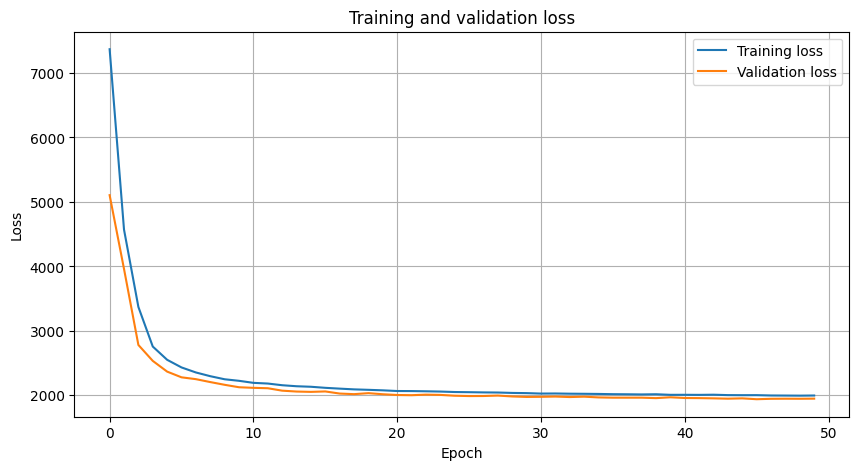

In [104]:
# Plot the training history

plt.figure(figsize=(10, 5))
plt.plot(cvae_history.history['reconstruction_loss'], label='Training loss')
plt.plot(cvae_history.history['val_reconstruction_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Training and validation loss')

plt.show()

### Appendix I: Generate Samples


Fitting class distributions...


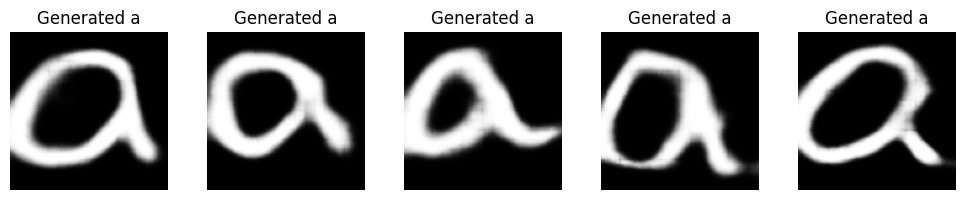

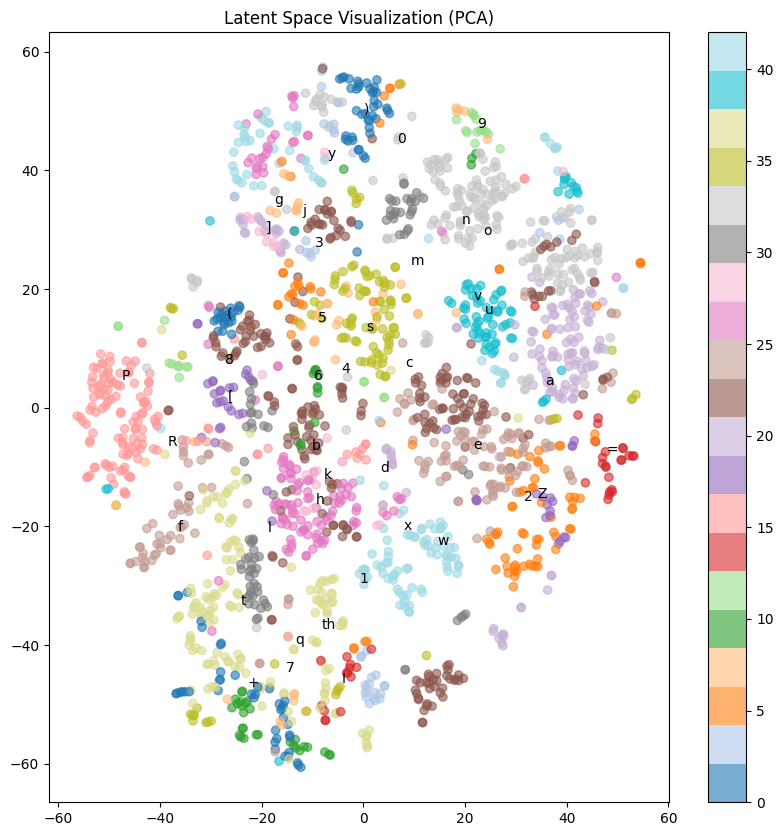

In [92]:
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from collections import defaultdict

def get_latent_representations(cvae, test_generator, min_samples_per_class=10):
    """
    Get latent space representations ensuring minimum samples per class
    """
    latent_vectors = []
    labels = []
    class_counts = defaultdict(int)
    
    # Reset the generator
    test_generator.reset()
    
    # Keep track of minimum samples needed
    num_classes = len(test_generator.class_indices)
    total_min_samples = num_classes * min_samples_per_class
    
    for images, batch_labels in test_generator:
        # Get the latent vectors
        z_mean, _, _ = cvae.encoder([images, batch_labels])
        batch_latent = z_mean.numpy()
        batch_labels_idx = np.argmax(batch_labels, axis=1)
        
        # Add to our collections
        latent_vectors.append(batch_latent)
        labels.extend(batch_labels_idx)
        
        # Update class counts
        for label in batch_labels_idx:
            class_counts[label] += 1
        
        # Check if we have enough samples for each class
        if min(class_counts.values()) >= min_samples_per_class:
            break
    
    latent_vectors = np.vstack(latent_vectors)
    labels = np.array(labels)
    
    return latent_vectors, labels

def fit_class_distributions(latent_vectors, labels, max_components=5):
    """
    Fit GMM for each class in the latent space, adapting n_components to sample size
    """
    class_models = {}
    unique_labels = np.unique(labels)
    
    for label in unique_labels:
        # Get latent vectors for this class
        class_vectors = latent_vectors[labels == label]
        
        # Determine number of components based on sample size
        n_samples = len(class_vectors)
        n_components = min(max_components, n_samples // 2)  # Ensure we have enough samples per component
        n_components = max(1, n_components)  # At least one component
        
        # Fit GMM
        gmm = GaussianMixture(
            n_components=n_components,
            covariance_type='full',
            random_state=42
        )
        gmm.fit(class_vectors)
        
        class_models[label] = gmm
    
    return class_models

def generate_samples(cvae, label_name, num_samples=5, class_models=None):
    """
    Generate samples for a specific character/label using class-specific latent distribution
    """
    if class_models is None:
        # Get latent representations and fit distributions
        latent_vectors, labels = get_latent_representations(cvae, train_generator)
        class_models = fit_class_distributions(latent_vectors, labels)
    
    class_indices = train_generator.class_indices
    label_idx = class_indices[label_name]
    
    # Create one-hot encoded label
    label_onehot = tf.keras.utils.to_categorical([label_idx], num_classes=len(class_indices))
    label_onehot = np.tile(label_onehot, [num_samples, 1])
    
    # Sample from the class-specific GMM
    z = class_models[label_idx].sample(num_samples)[0]
    z = tf.convert_to_tensor(z, dtype=tf.float32)
    label_onehot = tf.convert_to_tensor(label_onehot, dtype=tf.float32)
    
    # Generate images
    generated_images = cvae.decoder([z, label_onehot])
    generated_images = generated_images.numpy()
    
    # Plot the generated image. 
    plt.figure(figsize=(2*num_samples, 2))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(generated_images[i].squeeze(), cmap='gray')
        plt.axis('off')
        plt.title(f'Generated {label_name}')
    
    plt.tight_layout()
    plt.show()
    
    return generated_images

# You can also visualize the latent space
def plot_latent_space(latent_vectors, labels, class_indices):
    """
    Plot the latent space using PCA or t-SNE
    """
    # Reduce dimensionality for visualization using t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    latent_2d = tsne.fit_transform(latent_vectors)
    
    # Plot
    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], 
                         c=labels, cmap='tab20', alpha=0.6)
    plt.colorbar(scatter)
    
    # Add labels
    label_names = {v: k for k, v in class_indices.items()}
    for label in np.unique(labels):
        center = np.mean(latent_2d[labels == label], axis=0)
        plt.annotate(label_names[label], center)
    
    plt.title('Latent Space Visualization (t-SNE)')
    plt.show()

# First, get the latent distributions
print("Fitting class distributions...")
latent_vectors, labels = get_latent_representations(cvae, train_generator)
class_models = fit_class_distributions(latent_vectors, labels)

# Now generate samples using the fitted distributions
generate_samples(cvae, 'a', num_samples=5, class_models=class_models)

# Visualize the latent space
plot_latent_space(latent_vectors, labels, train_generator.class_indices)


Generating message: We made it to the end of the semester


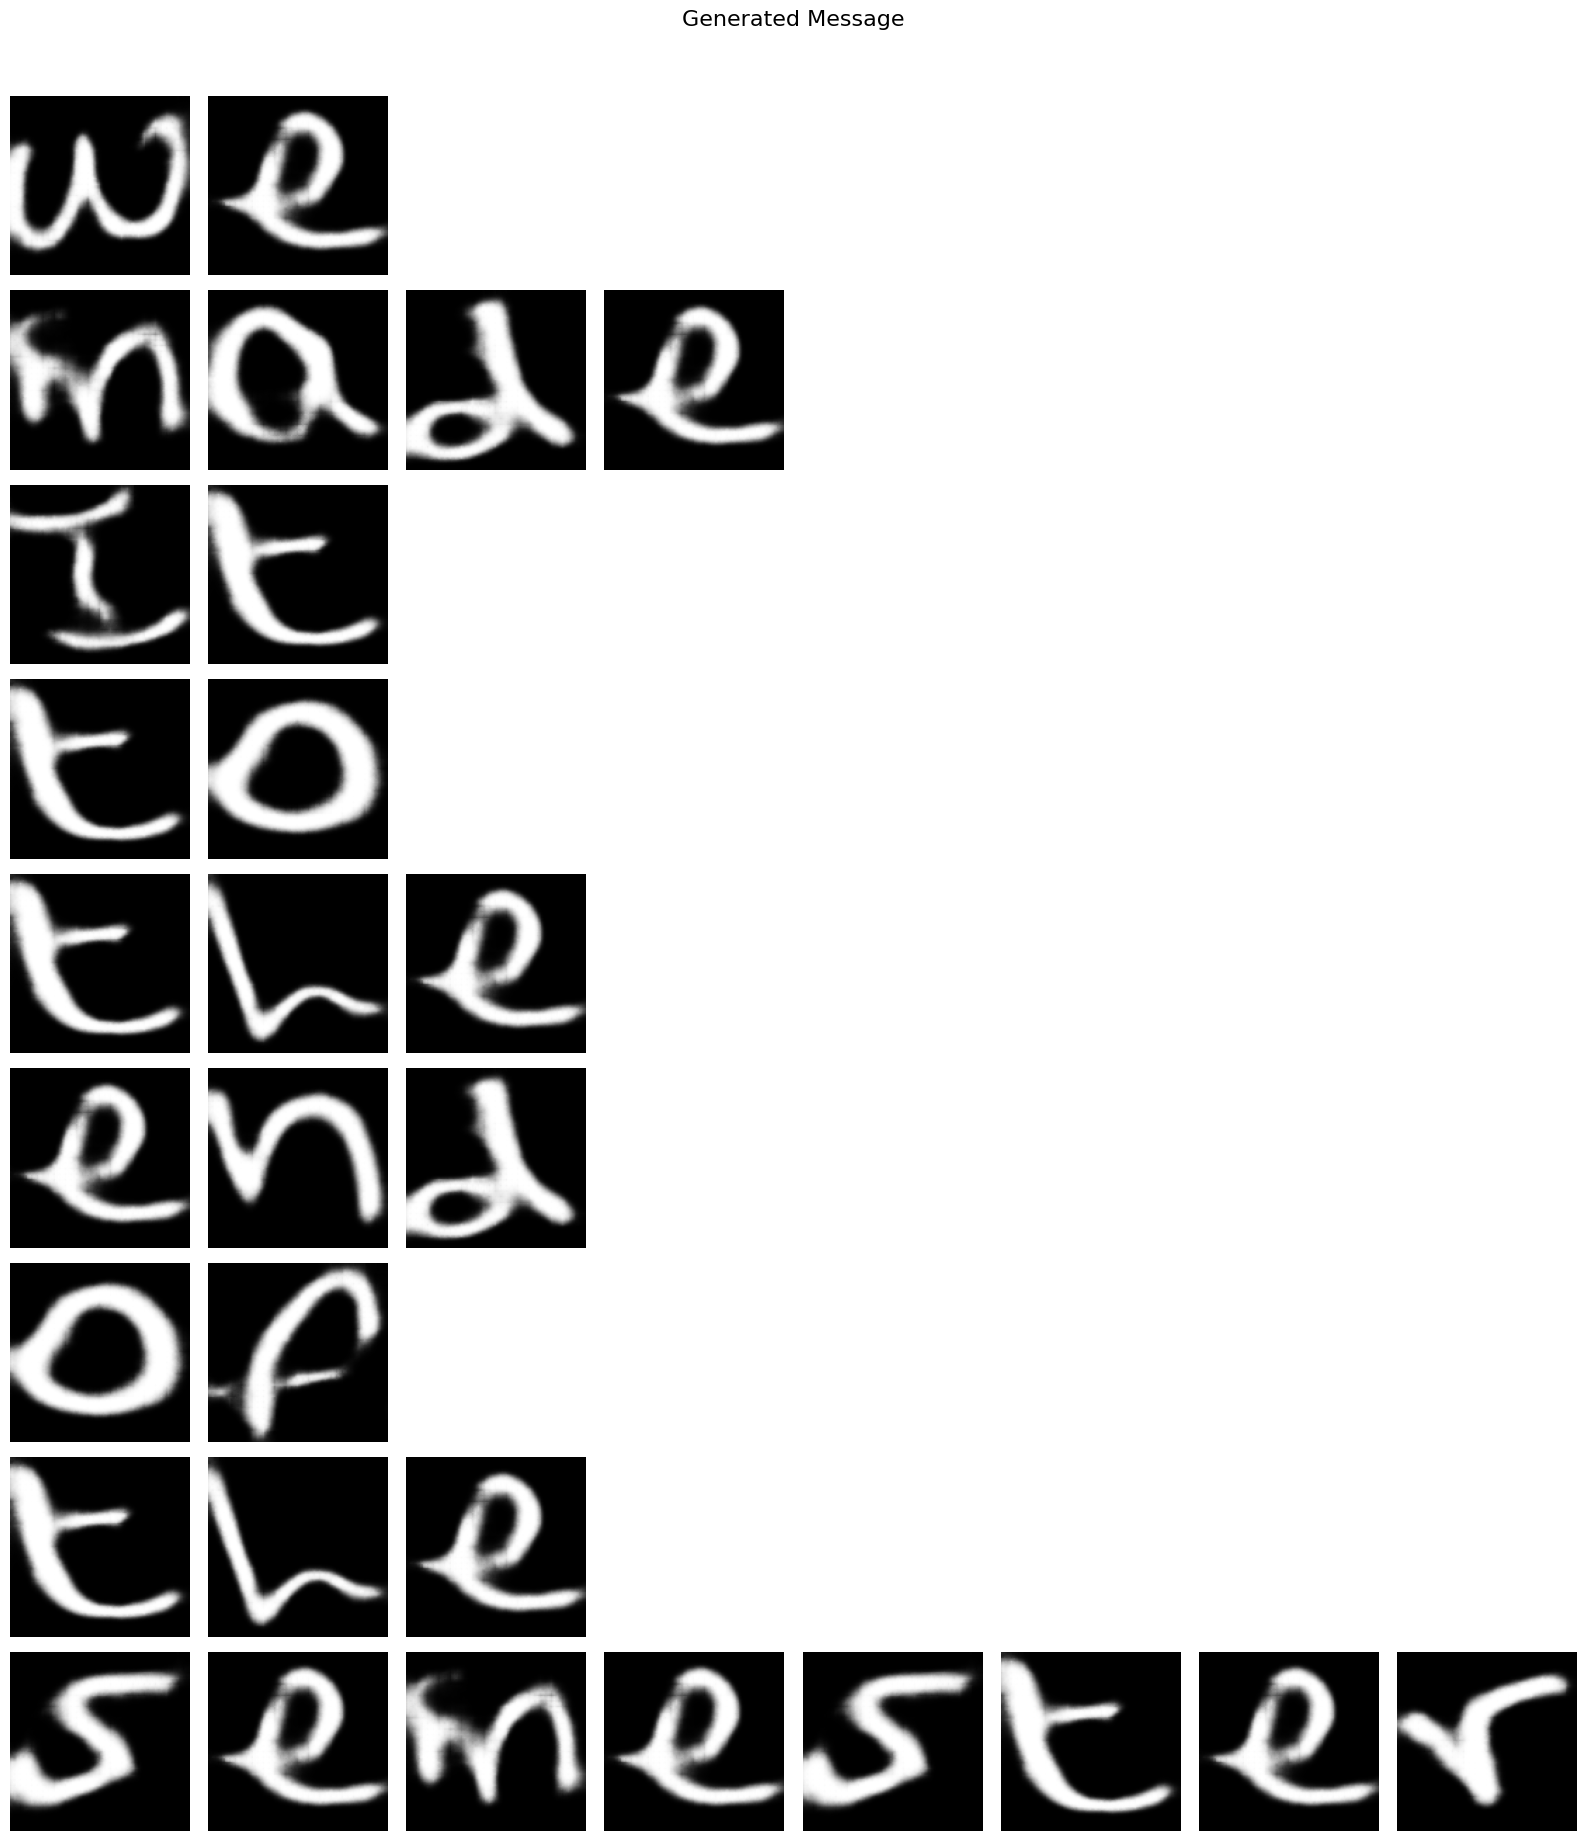

In [106]:
# Now let's try generating a message

def generate_message(cvae, message, class_models=None, samples_per_char=1):
    """
    Generate a more stylized message layout
    """
    message = message.lower()
    class_indices = test_generator.class_indices
    
    # Split into words
    words = message.split()
    max_word_len = max(len(word) for word in words)
    
    # Calculate layout
    n_rows = len(words)
    n_cols = max_word_len
    
    # Create figure with more spacing
    plt.figure(figsize=(2*n_cols, 2*n_rows))
    
    for row, word in enumerate(words):
        for col, char in enumerate(word):
            if char not in class_indices and char.upper() not in class_indices:
                print(f"Warning: '{char}' not in training set, skipping...")
                continue

            if char not in class_indices:
                char = char.upper()
                
            # Get label index and generate
            label_idx = class_indices[char]
            label_onehot = tf.keras.utils.to_categorical([label_idx], num_classes=len(class_indices))
            label_onehot = np.tile(label_onehot, (samples_per_char, 1))
            
            z = class_models[label_idx].sample(samples_per_char)[0]
            z = tf.convert_to_tensor(z, dtype=tf.float32)
            label_onehot = tf.convert_to_tensor(label_onehot, dtype=tf.float32)
            
            generated = cvae.decoder([z, label_onehot])
            
            # Plot in grid
            plt.subplot(n_rows, n_cols, row * n_cols + col + 1)
            plt.imshow(generated[0].numpy().squeeze(), cmap='gray')
            plt.axis('off')
    
    plt.suptitle("Generated Message", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# Generate the styled message
message = "We made it to the end of the semester"
print("\nGenerating message:", message)
latent_vectors, labels = get_latent_representations(cvae, test_generator)
class_models = fit_class_distributions(latent_vectors, labels)
generate_message(cvae, message, class_models=class_models)